# MLP 3 - MNIST

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_MLP, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [5]:
num_fc_layers = 4
num_fc_hidden = [1024, 1024, 1024]

In [6]:
dataset_config = dict(
    dataset=Dataset.MNIST.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [7]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dropout_rate=0.0,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    bias=False,
    debug=False,
)

In [8]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=28_000,
    subnet_decay_inv=500,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [9]:
config = dataset_config | network_config | training_config

## Run the configuration

Training on 60000 samples


Data normalized. New statistics:
-  Min: -31
-  Max: 127
- Mean: -7
-  Std: 53

Moved data to device: <CUDA Device 1>
Train set:  (60000, 1, 28, 28), (60000, 10)
Test set:   (10000, 1, 28, 28), (10000, 10)
Data types: (int8, int8)


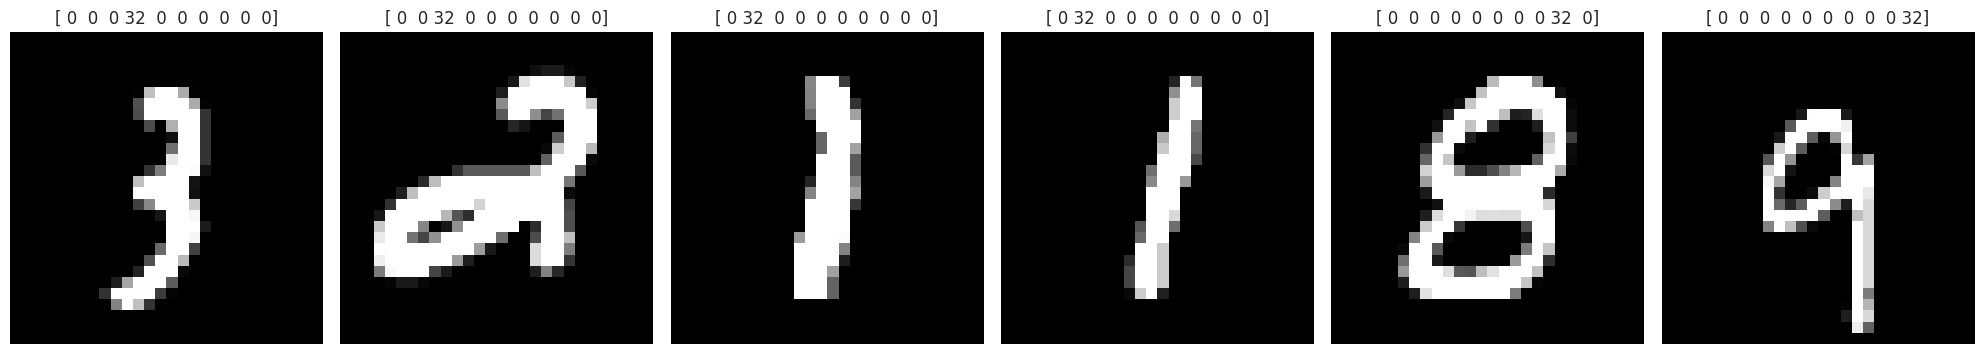

In [10]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [11]:
model = build_MLP(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossMLP(
	(0): Sequential(
			(0): Flatten()
			(1): LocalLinearBlock(
			(0): IntegerLinear(in_features=784, out_features=1024, bias=False, decay_rate_inv=28000)
			(1): ConstantScaling(fwd_factor=200704, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=1024, out_features=10, bias=False, decay_rate_inv=500)
			(1): ConstantScaling(fwd_factor=262144, bwd_factor=1)
		)
	)
			(2): LocalLinearBlock(
			(0): IntegerLinear(in_features=1024, out_features=1024, bias=False, decay_rate_inv=28000)
			(1): ConstantScaling(fwd_factor=262144, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=1024, out_features=10, bias=False, decay_rate_inv=500)
			(1): ConstantScaling(fwd_factor=262144, bwd_factor=1)
		)
	)
			(3): LocalLinearBlock(
			(0): IntegerLinear(in_features=1024, out_features=1024, bias=False, decay_rate_inv=28000)
			(1): C

In [12]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)
    
    # Build and train the model
    m = build_MLP(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [13]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...


Epoch   1/150 - Train accuracy: 10.264% - Test accuracy: 20.052%


Epoch   2/150 - Train accuracy: 59.482% - Test accuracy: 88.552%


Epoch   3/150 - Train accuracy: 83.660% - Test accuracy: 91.927%


Epoch   4/150 - Train accuracy: 85.939% - Test accuracy: 93.249%


Epoch   5/150 - Train accuracy: 89.114% - Test accuracy: 94.241%


Epoch   6/150 - Train accuracy: 90.565% - Test accuracy: 94.892%


Epoch   7/150 - Train accuracy: 91.682% - Test accuracy: 95.533%


Epoch   8/150 - Train accuracy: 92.716% - Test accuracy: 96.004%


Epoch   9/150 - Train accuracy: 93.527% - Test accuracy: 96.444%


Epoch  10/150 - Train accuracy: 93.927% - Test accuracy: 96.635%


Epoch  11/150 - Train accuracy: 94.302% - Test accuracy: 96.815%


Epoch  12/150 - Train accuracy: 94.734% - Test accuracy: 96.985%


Epoch  13/150 - Train accuracy: 95.131% - Test accuracy: 97.085%


Epoch  14/150 - Train accuracy: 95.279% - Test accuracy: 97.196%


Epoch  15/150 - Train accuracy: 95.583% - Test accuracy: 97.316%


Epoch  16/150 - Train accuracy: 95.874% - Test accuracy: 97.406%


Epoch  17/150 - Train accuracy: 95.921% - Test accuracy: 97.526%


Epoch  18/150 - Train accuracy: 95.978% - Test accuracy: 97.586%


Epoch  19/150 - Train accuracy: 96.156% - Test accuracy: 97.706%


Epoch  20/150 - Train accuracy: 96.326% - Test accuracy: 97.726%


Epoch  21/150 - Train accuracy: 96.405% - Test accuracy: 97.686%


Epoch  22/150 - Train accuracy: 96.420% - Test accuracy: 97.776%


Epoch  23/150 - Train accuracy: 96.625% - Test accuracy: 97.877%


Epoch  24/150 - Train accuracy: 96.620% - Test accuracy: 97.827%


Epoch  25/150 - Train accuracy: 96.810% - Test accuracy: 97.857%


Epoch  26/150 - Train accuracy: 96.920% - Test accuracy: 97.917%


Epoch  27/150 - Train accuracy: 96.943% - Test accuracy: 97.997%


Epoch  28/150 - Train accuracy: 97.075% - Test accuracy: 97.977%


Epoch  29/150 - Train accuracy: 97.065% - Test accuracy: 98.057%


Epoch  30/150 - Train accuracy: 97.037% - Test accuracy: 98.077%


Epoch  31/150 - Train accuracy: 97.107% - Test accuracy: 97.997%


Epoch  32/150 - Train accuracy: 97.194% - Test accuracy: 98.027%


Epoch  33/150 - Train accuracy: 97.225% - Test accuracy: 98.067%


Epoch  34/150 - Train accuracy: 97.295% - Test accuracy: 98.177%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 34
----------------------------------------------------------------


Epoch  35/150 - Train accuracy: 97.294% - Test accuracy: 98.067%


Epoch  36/150 - Train accuracy: 97.292% - Test accuracy: 98.097%


Epoch  37/150 - Train accuracy: 97.329% - Test accuracy: 98.187%


Epoch  38/150 - Train accuracy: 97.359% - Test accuracy: 98.167%


Epoch  39/150 - Train accuracy: 97.392% - Test accuracy: 98.237%


Epoch  40/150 - Train accuracy: 97.434% - Test accuracy: 98.217%


Epoch  41/150 - Train accuracy: 97.404% - Test accuracy: 98.217%


Epoch  42/150 - Train accuracy: 97.402% - Test accuracy: 98.207%


Epoch  43/150 - Train accuracy: 97.527% - Test accuracy: 98.157%


Epoch  44/150 - Train accuracy: 97.504% - Test accuracy: 98.217%


Epoch  45/150 - Train accuracy: 97.447% - Test accuracy: 98.207%


Epoch  46/150 - Train accuracy: 97.449% - Test accuracy: 98.227%


Epoch  47/150 - Train accuracy: 97.554% - Test accuracy: 98.217%


Epoch  48/150 - Train accuracy: 97.370% - Test accuracy: 98.227%


Epoch  49/150 - Train accuracy: 97.430% - Test accuracy: 98.227%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 49
----------------------------------------------------------------


Epoch  50/150 - Train accuracy: 97.469% - Test accuracy: 98.267%


Epoch  51/150 - Train accuracy: 97.544% - Test accuracy: 98.257%


Epoch  52/150 - Train accuracy: 97.592% - Test accuracy: 98.257%


Epoch  53/150 - Train accuracy: 97.400% - Test accuracy: 98.267%


Epoch  54/150 - Train accuracy: 97.597% - Test accuracy: 98.277%


Epoch  55/150 - Train accuracy: 97.487% - Test accuracy: 98.267%


Epoch  56/150 - Train accuracy: 97.454% - Test accuracy: 98.257%


Epoch  57/150 - Train accuracy: 97.560% - Test accuracy: 98.277%


Epoch  58/150 - Train accuracy: 97.525% - Test accuracy: 98.287%


Epoch  59/150 - Train accuracy: 97.542% - Test accuracy: 98.257%


Epoch  60/150 - Train accuracy: 97.442% - Test accuracy: 98.287%


Epoch  61/150 - Train accuracy: 97.504% - Test accuracy: 98.277%


Epoch  62/150 - Train accuracy: 97.590% - Test accuracy: 98.257%


Epoch  63/150 - Train accuracy: 97.554% - Test accuracy: 98.257%


Epoch  64/150 - Train accuracy: 97.495% - Test accuracy: 98.277%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 64
----------------------------------------------------------------


Epoch  65/150 - Train accuracy: 97.600% - Test accuracy: 98.287%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 43...


Epoch   1/150 - Train accuracy: 10.874% - Test accuracy: 22.135%


Epoch   2/150 - Train accuracy: 59.625% - Test accuracy: 88.381%


Epoch   3/150 - Train accuracy: 83.705% - Test accuracy: 92.067%


Epoch   4/150 - Train accuracy: 86.183% - Test accuracy: 93.249%


Epoch   5/150 - Train accuracy: 88.727% - Test accuracy: 94.361%


Epoch   6/150 - Train accuracy: 90.807% - Test accuracy: 95.002%


Epoch   7/150 - Train accuracy: 91.924% - Test accuracy: 95.523%


Epoch   8/150 - Train accuracy: 92.453% - Test accuracy: 95.964%


Epoch   9/150 - Train accuracy: 93.293% - Test accuracy: 96.434%


Epoch  10/150 - Train accuracy: 93.992% - Test accuracy: 96.575%


Epoch  11/150 - Train accuracy: 94.252% - Test accuracy: 96.815%


Epoch  12/150 - Train accuracy: 94.836% - Test accuracy: 96.975%


Epoch  13/150 - Train accuracy: 95.192% - Test accuracy: 97.005%


Epoch  14/150 - Train accuracy: 95.393% - Test accuracy: 97.226%


Epoch  15/150 - Train accuracy: 95.561% - Test accuracy: 97.346%


Epoch  16/150 - Train accuracy: 95.716% - Test accuracy: 97.426%


Epoch  17/150 - Train accuracy: 95.899% - Test accuracy: 97.576%


Epoch  18/150 - Train accuracy: 95.941% - Test accuracy: 97.536%


Epoch  19/150 - Train accuracy: 96.101% - Test accuracy: 97.626%


Epoch  20/150 - Train accuracy: 96.240% - Test accuracy: 97.726%


Epoch  21/150 - Train accuracy: 96.461% - Test accuracy: 97.706%


Epoch  22/150 - Train accuracy: 96.550% - Test accuracy: 97.786%


Epoch  23/150 - Train accuracy: 96.478% - Test accuracy: 97.786%


Epoch  24/150 - Train accuracy: 96.655% - Test accuracy: 97.756%


Epoch  25/150 - Train accuracy: 96.678% - Test accuracy: 97.877%


Epoch  26/150 - Train accuracy: 96.792% - Test accuracy: 97.887%


Epoch  27/150 - Train accuracy: 96.860% - Test accuracy: 97.897%


Epoch  28/150 - Train accuracy: 96.945% - Test accuracy: 97.917%


Epoch  29/150 - Train accuracy: 96.943% - Test accuracy: 97.957%


Epoch  30/150 - Train accuracy: 97.095% - Test accuracy: 97.977%


Epoch  31/150 - Train accuracy: 97.147% - Test accuracy: 98.017%


Epoch  32/150 - Train accuracy: 97.090% - Test accuracy: 98.047%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 32
----------------------------------------------------------------


Epoch  33/150 - Train accuracy: 97.202% - Test accuracy: 98.037%


Epoch  34/150 - Train accuracy: 97.277% - Test accuracy: 98.067%


Epoch  35/150 - Train accuracy: 97.110% - Test accuracy: 98.077%


Epoch  36/150 - Train accuracy: 97.192% - Test accuracy: 98.077%


Epoch  37/150 - Train accuracy: 97.163% - Test accuracy: 98.087%


Epoch  38/150 - Train accuracy: 97.325% - Test accuracy: 98.077%


Epoch  39/150 - Train accuracy: 97.309% - Test accuracy: 98.097%


Epoch  40/150 - Train accuracy: 97.464% - Test accuracy: 98.127%


Epoch  41/150 - Train accuracy: 97.347% - Test accuracy: 98.137%


Epoch  42/150 - Train accuracy: 97.322% - Test accuracy: 98.137%


Epoch  43/150 - Train accuracy: 97.297% - Test accuracy: 98.127%


Epoch  44/150 - Train accuracy: 97.335% - Test accuracy: 98.117%


Epoch  45/150 - Train accuracy: 97.337% - Test accuracy: 98.137%


Epoch  46/150 - Train accuracy: 97.379% - Test accuracy: 98.137%


Epoch  47/150 - Train accuracy: 97.319% - Test accuracy: 98.167%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 47
----------------------------------------------------------------


Epoch  48/150 - Train accuracy: 97.437% - Test accuracy: 98.147%


Epoch  49/150 - Train accuracy: 97.267% - Test accuracy: 98.197%


Epoch  50/150 - Train accuracy: 97.350% - Test accuracy: 98.157%


Epoch  51/150 - Train accuracy: 97.330% - Test accuracy: 98.147%


Epoch  52/150 - Train accuracy: 97.494% - Test accuracy: 98.187%


Epoch  53/150 - Train accuracy: 97.405% - Test accuracy: 98.187%


Epoch  54/150 - Train accuracy: 97.450% - Test accuracy: 98.147%


Epoch  55/150 - Train accuracy: 97.365% - Test accuracy: 98.167%


Epoch  56/150 - Train accuracy: 97.425% - Test accuracy: 98.187%


Epoch  57/150 - Train accuracy: 97.519% - Test accuracy: 98.167%


Epoch  58/150 - Train accuracy: 97.380% - Test accuracy: 98.197%


Epoch  59/150 - Train accuracy: 97.385% - Test accuracy: 98.177%


Epoch  60/150 - Train accuracy: 97.519% - Test accuracy: 98.177%


Epoch  61/150 - Train accuracy: 97.485% - Test accuracy: 98.187%


Epoch  62/150 - Train accuracy: 97.449% - Test accuracy: 98.177%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 62
----------------------------------------------------------------


Epoch  63/150 - Train accuracy: 97.529% - Test accuracy: 98.177%


Epoch  64/150 - Train accuracy: 97.424% - Test accuracy: 98.177%


Epoch  65/150 - Train accuracy: 97.409% - Test accuracy: 98.177%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 44...


Epoch   1/150 - Train accuracy: 10.300% - Test accuracy: 08.914%


Epoch   2/150 - Train accuracy: 60.961% - Test accuracy: 88.912%


Epoch   3/150 - Train accuracy: 83.226% - Test accuracy: 92.037%


Epoch   4/150 - Train accuracy: 86.733% - Test accuracy: 93.289%


Epoch   5/150 - Train accuracy: 88.959% - Test accuracy: 94.501%


Epoch   6/150 - Train accuracy: 90.855% - Test accuracy: 95.162%


Epoch   7/150 - Train accuracy: 92.041% - Test accuracy: 95.663%


Epoch   8/150 - Train accuracy: 92.825% - Test accuracy: 95.994%


Epoch   9/150 - Train accuracy: 93.485% - Test accuracy: 96.214%


Epoch  10/150 - Train accuracy: 93.945% - Test accuracy: 96.585%


Epoch  11/150 - Train accuracy: 94.522% - Test accuracy: 96.745%


Epoch  12/150 - Train accuracy: 94.816% - Test accuracy: 96.905%


Epoch  13/150 - Train accuracy: 95.069% - Test accuracy: 97.015%


Epoch  14/150 - Train accuracy: 95.351% - Test accuracy: 97.196%


Epoch  15/150 - Train accuracy: 95.548% - Test accuracy: 97.246%


Epoch  16/150 - Train accuracy: 95.843% - Test accuracy: 97.376%


Epoch  17/150 - Train accuracy: 95.739% - Test accuracy: 97.496%


Epoch  18/150 - Train accuracy: 96.180% - Test accuracy: 97.546%


Epoch  19/150 - Train accuracy: 96.043% - Test accuracy: 97.556%


Epoch  20/150 - Train accuracy: 96.316% - Test accuracy: 97.706%


Epoch  21/150 - Train accuracy: 96.531% - Test accuracy: 97.726%


Epoch  22/150 - Train accuracy: 96.565% - Test accuracy: 97.776%


Epoch  23/150 - Train accuracy: 96.595% - Test accuracy: 97.827%


Epoch  24/150 - Train accuracy: 96.673% - Test accuracy: 97.837%


Epoch  25/150 - Train accuracy: 96.780% - Test accuracy: 97.806%


Epoch  26/150 - Train accuracy: 96.710% - Test accuracy: 97.927%


Epoch  27/150 - Train accuracy: 96.877% - Test accuracy: 97.907%


Epoch  28/150 - Train accuracy: 96.833% - Test accuracy: 97.967%


Epoch  29/150 - Train accuracy: 97.065% - Test accuracy: 97.997%


Epoch  30/150 - Train accuracy: 97.008% - Test accuracy: 98.057%


Epoch  31/150 - Train accuracy: 96.963% - Test accuracy: 98.057%


Epoch  32/150 - Train accuracy: 97.138% - Test accuracy: 98.107%


Epoch  33/150 - Train accuracy: 97.314% - Test accuracy: 98.127%


Epoch  34/150 - Train accuracy: 97.315% - Test accuracy: 98.157%


Epoch  35/150 - Train accuracy: 97.299% - Test accuracy: 98.187%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 97.349% - Test accuracy: 98.187%


Epoch  37/150 - Train accuracy: 97.332% - Test accuracy: 98.177%


Epoch  38/150 - Train accuracy: 97.347% - Test accuracy: 98.197%


Epoch  39/150 - Train accuracy: 97.354% - Test accuracy: 98.197%


Epoch  40/150 - Train accuracy: 97.380% - Test accuracy: 98.167%


Epoch  41/150 - Train accuracy: 97.287% - Test accuracy: 98.217%


Epoch  42/150 - Train accuracy: 97.420% - Test accuracy: 98.227%


Epoch  43/150 - Train accuracy: 97.460% - Test accuracy: 98.237%


Epoch  44/150 - Train accuracy: 97.479% - Test accuracy: 98.247%


Epoch  45/150 - Train accuracy: 97.544% - Test accuracy: 98.217%


Epoch  46/150 - Train accuracy: 97.302% - Test accuracy: 98.207%


Epoch  47/150 - Train accuracy: 97.539% - Test accuracy: 98.227%


Epoch  48/150 - Train accuracy: 97.527% - Test accuracy: 98.247%


Epoch  49/150 - Train accuracy: 97.504% - Test accuracy: 98.287%


Epoch  50/150 - Train accuracy: 97.552% - Test accuracy: 98.297%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 97.487% - Test accuracy: 98.287%


Epoch  52/150 - Train accuracy: 97.525% - Test accuracy: 98.277%


Epoch  53/150 - Train accuracy: 97.582% - Test accuracy: 98.277%


Epoch  54/150 - Train accuracy: 97.554% - Test accuracy: 98.287%


Epoch  55/150 - Train accuracy: 97.514% - Test accuracy: 98.257%


Epoch  56/150 - Train accuracy: 97.674% - Test accuracy: 98.297%


Epoch  57/150 - Train accuracy: 97.530% - Test accuracy: 98.287%


Epoch  58/150 - Train accuracy: 97.542% - Test accuracy: 98.287%


Epoch  59/150 - Train accuracy: 97.515% - Test accuracy: 98.287%


Epoch  60/150 - Train accuracy: 97.599% - Test accuracy: 98.307%


Epoch  61/150 - Train accuracy: 97.467% - Test accuracy: 98.287%


Epoch  62/150 - Train accuracy: 97.467% - Test accuracy: 98.277%


Epoch  63/150 - Train accuracy: 97.634% - Test accuracy: 98.287%


Epoch  64/150 - Train accuracy: 97.427% - Test accuracy: 98.287%


Epoch  65/150 - Train accuracy: 97.507% - Test accuracy: 98.287%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 45...


Epoch   1/150 - Train accuracy: 10.571% - Test accuracy: 11.428%


Epoch   2/150 - Train accuracy: 59.685% - Test accuracy: 89.143%


Epoch   3/150 - Train accuracy: 83.408% - Test accuracy: 91.967%


Epoch   4/150 - Train accuracy: 86.418% - Test accuracy: 93.139%


Epoch   5/150 - Train accuracy: 88.527% - Test accuracy: 94.181%


Epoch   6/150 - Train accuracy: 90.635% - Test accuracy: 95.062%


Epoch   7/150 - Train accuracy: 91.859% - Test accuracy: 95.673%


Epoch   8/150 - Train accuracy: 92.853% - Test accuracy: 95.974%


Epoch   9/150 - Train accuracy: 93.276% - Test accuracy: 96.334%


Epoch  10/150 - Train accuracy: 93.838% - Test accuracy: 96.585%


Epoch  11/150 - Train accuracy: 94.509% - Test accuracy: 96.805%


Epoch  12/150 - Train accuracy: 94.822% - Test accuracy: 96.915%


Epoch  13/150 - Train accuracy: 94.917% - Test accuracy: 97.055%


Epoch  14/150 - Train accuracy: 95.358% - Test accuracy: 97.135%


Epoch  15/150 - Train accuracy: 95.553% - Test accuracy: 97.246%


Epoch  16/150 - Train accuracy: 95.654% - Test accuracy: 97.336%


Epoch  17/150 - Train accuracy: 95.741% - Test accuracy: 97.396%


Epoch  18/150 - Train accuracy: 96.055% - Test accuracy: 97.546%


Epoch  19/150 - Train accuracy: 96.090% - Test accuracy: 97.626%


Epoch  20/150 - Train accuracy: 96.285% - Test accuracy: 97.706%


Epoch  21/150 - Train accuracy: 96.328% - Test accuracy: 97.686%


Epoch  22/150 - Train accuracy: 96.311% - Test accuracy: 97.706%


Epoch  23/150 - Train accuracy: 96.415% - Test accuracy: 97.736%


Epoch  24/150 - Train accuracy: 96.620% - Test accuracy: 97.877%


Epoch  25/150 - Train accuracy: 96.647% - Test accuracy: 97.917%


Epoch  26/150 - Train accuracy: 96.673% - Test accuracy: 97.947%


Epoch  27/150 - Train accuracy: 96.922% - Test accuracy: 97.917%


Epoch  28/150 - Train accuracy: 96.917% - Test accuracy: 98.047%


Epoch  29/150 - Train accuracy: 96.957% - Test accuracy: 97.997%


Epoch  30/150 - Train accuracy: 96.992% - Test accuracy: 98.037%


Epoch  31/150 - Train accuracy: 97.007% - Test accuracy: 98.117%


Epoch  32/150 - Train accuracy: 97.073% - Test accuracy: 98.147%


Epoch  33/150 - Train accuracy: 97.100% - Test accuracy: 98.137%


Epoch  34/150 - Train accuracy: 97.282% - Test accuracy: 98.197%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 34
----------------------------------------------------------------


Epoch  35/150 - Train accuracy: 97.299% - Test accuracy: 98.187%


Epoch  36/150 - Train accuracy: 97.365% - Test accuracy: 98.167%


Epoch  37/150 - Train accuracy: 97.294% - Test accuracy: 98.197%


Epoch  38/150 - Train accuracy: 97.279% - Test accuracy: 98.167%


Epoch  39/150 - Train accuracy: 97.305% - Test accuracy: 98.197%


Epoch  40/150 - Train accuracy: 97.370% - Test accuracy: 98.197%


Epoch  41/150 - Train accuracy: 97.264% - Test accuracy: 98.217%


Epoch  42/150 - Train accuracy: 97.384% - Test accuracy: 98.187%


Epoch  43/150 - Train accuracy: 97.414% - Test accuracy: 98.247%


Epoch  44/150 - Train accuracy: 97.390% - Test accuracy: 98.237%


Epoch  45/150 - Train accuracy: 97.427% - Test accuracy: 98.217%


Epoch  46/150 - Train accuracy: 97.407% - Test accuracy: 98.207%


Epoch  47/150 - Train accuracy: 97.397% - Test accuracy: 98.257%


Epoch  48/150 - Train accuracy: 97.410% - Test accuracy: 98.267%


Epoch  49/150 - Train accuracy: 97.409% - Test accuracy: 98.247%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 49
----------------------------------------------------------------


Epoch  50/150 - Train accuracy: 97.474% - Test accuracy: 98.257%


Epoch  51/150 - Train accuracy: 97.495% - Test accuracy: 98.227%


Epoch  52/150 - Train accuracy: 97.447% - Test accuracy: 98.257%


Epoch  53/150 - Train accuracy: 97.514% - Test accuracy: 98.267%


Epoch  54/150 - Train accuracy: 97.410% - Test accuracy: 98.267%


Epoch  55/150 - Train accuracy: 97.474% - Test accuracy: 98.297%


Epoch  56/150 - Train accuracy: 97.504% - Test accuracy: 98.307%


Epoch  57/150 - Train accuracy: 97.474% - Test accuracy: 98.287%


Epoch  58/150 - Train accuracy: 97.429% - Test accuracy: 98.287%


Epoch  59/150 - Train accuracy: 97.499% - Test accuracy: 98.277%


Epoch  60/150 - Train accuracy: 97.500% - Test accuracy: 98.287%


Epoch  61/150 - Train accuracy: 97.515% - Test accuracy: 98.287%


Epoch  62/150 - Train accuracy: 97.532% - Test accuracy: 98.297%


Epoch  63/150 - Train accuracy: 97.630% - Test accuracy: 98.307%


Epoch  64/150 - Train accuracy: 97.402% - Test accuracy: 98.287%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 64
----------------------------------------------------------------


Epoch  65/150 - Train accuracy: 97.534% - Test accuracy: 98.287%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 46...


Epoch   1/150 - Train accuracy: 10.737% - Test accuracy: 14.694%


Epoch   2/150 - Train accuracy: 59.709% - Test accuracy: 88.792%


Epoch   3/150 - Train accuracy: 83.520% - Test accuracy: 91.807%


Epoch   4/150 - Train accuracy: 86.264% - Test accuracy: 93.219%


Epoch   5/150 - Train accuracy: 88.706% - Test accuracy: 94.321%


Epoch   6/150 - Train accuracy: 90.467% - Test accuracy: 95.082%


Epoch   7/150 - Train accuracy: 92.054% - Test accuracy: 95.633%


Epoch   8/150 - Train accuracy: 92.791% - Test accuracy: 95.954%


Epoch   9/150 - Train accuracy: 93.712% - Test accuracy: 96.374%


Epoch  10/150 - Train accuracy: 94.155% - Test accuracy: 96.585%


Epoch  11/150 - Train accuracy: 94.595% - Test accuracy: 96.845%


Epoch  12/150 - Train accuracy: 95.031% - Test accuracy: 96.925%


Epoch  13/150 - Train accuracy: 95.184% - Test accuracy: 97.085%


Epoch  14/150 - Train accuracy: 95.511% - Test accuracy: 97.236%


Epoch  15/150 - Train accuracy: 95.591% - Test accuracy: 97.396%


Epoch  16/150 - Train accuracy: 95.836% - Test accuracy: 97.416%


Epoch  17/150 - Train accuracy: 96.158% - Test accuracy: 97.466%


Epoch  18/150 - Train accuracy: 96.103% - Test accuracy: 97.526%


Epoch  19/150 - Train accuracy: 96.278% - Test accuracy: 97.506%


Epoch  20/150 - Train accuracy: 96.361% - Test accuracy: 97.596%


Epoch  21/150 - Train accuracy: 96.386% - Test accuracy: 97.616%


Epoch  22/150 - Train accuracy: 96.488% - Test accuracy: 97.746%


Epoch  23/150 - Train accuracy: 96.583% - Test accuracy: 97.776%


Epoch  24/150 - Train accuracy: 96.693% - Test accuracy: 97.907%


Epoch  25/150 - Train accuracy: 96.815% - Test accuracy: 97.907%


Epoch  26/150 - Train accuracy: 96.822% - Test accuracy: 97.937%


Epoch  27/150 - Train accuracy: 96.920% - Test accuracy: 97.967%


Epoch  28/150 - Train accuracy: 96.977% - Test accuracy: 97.987%


Epoch  29/150 - Train accuracy: 97.007% - Test accuracy: 98.007%


Epoch  30/150 - Train accuracy: 97.113% - Test accuracy: 98.017%


Epoch  31/150 - Train accuracy: 97.219% - Test accuracy: 97.997%


Epoch  32/150 - Train accuracy: 97.270% - Test accuracy: 98.037%


Epoch  33/150 - Train accuracy: 97.267% - Test accuracy: 98.037%


Epoch  34/150 - Train accuracy: 97.452% - Test accuracy: 98.087%


Epoch  35/150 - Train accuracy: 97.357% - Test accuracy: 98.077%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 97.305% - Test accuracy: 98.077%


Epoch  37/150 - Train accuracy: 97.440% - Test accuracy: 98.087%


Epoch  38/150 - Train accuracy: 97.439% - Test accuracy: 98.097%


Epoch  39/150 - Train accuracy: 97.410% - Test accuracy: 98.117%


Epoch  40/150 - Train accuracy: 97.430% - Test accuracy: 98.127%


Epoch  41/150 - Train accuracy: 97.487% - Test accuracy: 98.137%


Epoch  42/150 - Train accuracy: 97.419% - Test accuracy: 98.127%


Epoch  43/150 - Train accuracy: 97.590% - Test accuracy: 98.167%


Epoch  44/150 - Train accuracy: 97.380% - Test accuracy: 98.147%


Epoch  45/150 - Train accuracy: 97.419% - Test accuracy: 98.157%


Epoch  46/150 - Train accuracy: 97.619% - Test accuracy: 98.197%


Epoch  47/150 - Train accuracy: 97.534% - Test accuracy: 98.177%


Epoch  48/150 - Train accuracy: 97.612% - Test accuracy: 98.197%


Epoch  49/150 - Train accuracy: 97.537% - Test accuracy: 98.207%


Epoch  50/150 - Train accuracy: 97.454% - Test accuracy: 98.207%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 97.570% - Test accuracy: 98.197%


Epoch  52/150 - Train accuracy: 97.527% - Test accuracy: 98.197%


Epoch  53/150 - Train accuracy: 97.565% - Test accuracy: 98.217%


Epoch  54/150 - Train accuracy: 97.570% - Test accuracy: 98.217%


Epoch  55/150 - Train accuracy: 97.632% - Test accuracy: 98.207%


Epoch  56/150 - Train accuracy: 97.579% - Test accuracy: 98.207%


Epoch  57/150 - Train accuracy: 97.522% - Test accuracy: 98.237%


Epoch  58/150 - Train accuracy: 97.629% - Test accuracy: 98.207%


Epoch  59/150 - Train accuracy: 97.532% - Test accuracy: 98.197%


Epoch  60/150 - Train accuracy: 97.694% - Test accuracy: 98.197%


Epoch  61/150 - Train accuracy: 97.582% - Test accuracy: 98.217%


Epoch  62/150 - Train accuracy: 97.645% - Test accuracy: 98.207%


Epoch  63/150 - Train accuracy: 97.519% - Test accuracy: 98.227%


Epoch  64/150 - Train accuracy: 97.614% - Test accuracy: 98.217%


Epoch  65/150 - Train accuracy: 97.600% - Test accuracy: 98.197%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 47...


Epoch   1/150 - Train accuracy: 10.679% - Test accuracy: 20.082%


Epoch   2/150 - Train accuracy: 61.368% - Test accuracy: 89.103%


Epoch   3/150 - Train accuracy: 83.488% - Test accuracy: 91.526%


Epoch   4/150 - Train accuracy: 86.276% - Test accuracy: 93.029%


Epoch   5/150 - Train accuracy: 88.195% - Test accuracy: 94.131%


Epoch   6/150 - Train accuracy: 90.415% - Test accuracy: 94.882%


Epoch   7/150 - Train accuracy: 91.599% - Test accuracy: 95.353%


Epoch   8/150 - Train accuracy: 92.693% - Test accuracy: 96.054%


Epoch   9/150 - Train accuracy: 93.503% - Test accuracy: 96.314%


Epoch  10/150 - Train accuracy: 94.033% - Test accuracy: 96.735%


Epoch  11/150 - Train accuracy: 94.310% - Test accuracy: 96.735%


Epoch  12/150 - Train accuracy: 94.721% - Test accuracy: 96.935%


Epoch  13/150 - Train accuracy: 95.049% - Test accuracy: 97.075%


Epoch  14/150 - Train accuracy: 95.211% - Test accuracy: 97.206%


Epoch  15/150 - Train accuracy: 95.488% - Test accuracy: 97.326%


Epoch  16/150 - Train accuracy: 95.724% - Test accuracy: 97.326%


Epoch  17/150 - Train accuracy: 95.973% - Test accuracy: 97.456%


Epoch  18/150 - Train accuracy: 96.021% - Test accuracy: 97.506%


Epoch  19/150 - Train accuracy: 96.116% - Test accuracy: 97.576%


Epoch  20/150 - Train accuracy: 96.210% - Test accuracy: 97.556%


Epoch  21/150 - Train accuracy: 96.350% - Test accuracy: 97.696%


Epoch  22/150 - Train accuracy: 96.598% - Test accuracy: 97.766%


Epoch  23/150 - Train accuracy: 96.543% - Test accuracy: 97.806%


Epoch  24/150 - Train accuracy: 96.668% - Test accuracy: 97.827%


Epoch  25/150 - Train accuracy: 96.738% - Test accuracy: 97.837%


Epoch  26/150 - Train accuracy: 96.800% - Test accuracy: 97.857%


Epoch  27/150 - Train accuracy: 97.018% - Test accuracy: 97.917%


Epoch  28/150 - Train accuracy: 96.862% - Test accuracy: 97.927%


Epoch  29/150 - Train accuracy: 96.953% - Test accuracy: 97.997%


Epoch  30/150 - Train accuracy: 96.983% - Test accuracy: 97.967%


Epoch  31/150 - Train accuracy: 97.025% - Test accuracy: 98.027%


Epoch  32/150 - Train accuracy: 97.194% - Test accuracy: 98.017%


Epoch  33/150 - Train accuracy: 97.075% - Test accuracy: 97.987%


Epoch  34/150 - Train accuracy: 97.252% - Test accuracy: 98.047%


Epoch  35/150 - Train accuracy: 97.237% - Test accuracy: 98.137%


Epoch  36/150 - Train accuracy: 97.339% - Test accuracy: 98.107%


Epoch  37/150 - Train accuracy: 97.409% - Test accuracy: 98.207%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 37
----------------------------------------------------------------


Epoch  38/150 - Train accuracy: 97.435% - Test accuracy: 98.177%


Epoch  39/150 - Train accuracy: 97.390% - Test accuracy: 98.177%


Epoch  40/150 - Train accuracy: 97.450% - Test accuracy: 98.197%


Epoch  41/150 - Train accuracy: 97.382% - Test accuracy: 98.147%


Epoch  42/150 - Train accuracy: 97.417% - Test accuracy: 98.237%


Epoch  43/150 - Train accuracy: 97.579% - Test accuracy: 98.237%


Epoch  44/150 - Train accuracy: 97.439% - Test accuracy: 98.197%


Epoch  45/150 - Train accuracy: 97.547% - Test accuracy: 98.287%


Epoch  46/150 - Train accuracy: 97.552% - Test accuracy: 98.227%


Epoch  47/150 - Train accuracy: 97.575% - Test accuracy: 98.257%


Epoch  48/150 - Train accuracy: 97.577% - Test accuracy: 98.297%


Epoch  49/150 - Train accuracy: 97.489% - Test accuracy: 98.267%


Epoch  50/150 - Train accuracy: 97.557% - Test accuracy: 98.317%


Epoch  51/150 - Train accuracy: 97.644% - Test accuracy: 98.277%


Epoch  52/150 - Train accuracy: 97.547% - Test accuracy: 98.317%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 52
----------------------------------------------------------------


Epoch  53/150 - Train accuracy: 97.549% - Test accuracy: 98.257%


Epoch  54/150 - Train accuracy: 97.624% - Test accuracy: 98.287%


Epoch  55/150 - Train accuracy: 97.645% - Test accuracy: 98.277%


Epoch  56/150 - Train accuracy: 97.657% - Test accuracy: 98.317%


Epoch  57/150 - Train accuracy: 97.635% - Test accuracy: 98.287%


Epoch  58/150 - Train accuracy: 97.555% - Test accuracy: 98.307%


Epoch  59/150 - Train accuracy: 97.687% - Test accuracy: 98.307%


Epoch  60/150 - Train accuracy: 97.567% - Test accuracy: 98.307%


Epoch  61/150 - Train accuracy: 97.600% - Test accuracy: 98.297%


Epoch  62/150 - Train accuracy: 97.577% - Test accuracy: 98.297%


Epoch  63/150 - Train accuracy: 97.655% - Test accuracy: 98.277%


Epoch  64/150 - Train accuracy: 97.662% - Test accuracy: 98.317%


Epoch  65/150 - Train accuracy: 97.589% - Test accuracy: 98.327%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 48...


Epoch   1/150 - Train accuracy: 10.624% - Test accuracy: 11.458%


Epoch   2/150 - Train accuracy: 59.147% - Test accuracy: 89.093%


Epoch   3/150 - Train accuracy: 82.984% - Test accuracy: 91.667%


Epoch   4/150 - Train accuracy: 86.703% - Test accuracy: 93.139%


Epoch   5/150 - Train accuracy: 89.084% - Test accuracy: 93.890%


Epoch   6/150 - Train accuracy: 90.775% - Test accuracy: 95.012%


Epoch   7/150 - Train accuracy: 91.734% - Test accuracy: 95.683%


Epoch   8/150 - Train accuracy: 92.773% - Test accuracy: 96.104%


Epoch   9/150 - Train accuracy: 93.358% - Test accuracy: 96.434%


Epoch  10/150 - Train accuracy: 94.018% - Test accuracy: 96.605%


Epoch  11/150 - Train accuracy: 94.480% - Test accuracy: 96.835%


Epoch  12/150 - Train accuracy: 94.719% - Test accuracy: 97.025%


Epoch  13/150 - Train accuracy: 95.142% - Test accuracy: 97.125%


Epoch  14/150 - Train accuracy: 95.396% - Test accuracy: 97.216%


Epoch  15/150 - Train accuracy: 95.543% - Test accuracy: 97.346%


Epoch  16/150 - Train accuracy: 95.738% - Test accuracy: 97.406%


Epoch  17/150 - Train accuracy: 95.970% - Test accuracy: 97.576%


Epoch  18/150 - Train accuracy: 95.938% - Test accuracy: 97.536%


Epoch  19/150 - Train accuracy: 96.291% - Test accuracy: 97.576%


Epoch  20/150 - Train accuracy: 96.265% - Test accuracy: 97.656%


Epoch  21/150 - Train accuracy: 96.306% - Test accuracy: 97.686%


Epoch  22/150 - Train accuracy: 96.430% - Test accuracy: 97.716%


Epoch  23/150 - Train accuracy: 96.648% - Test accuracy: 97.756%


Epoch  24/150 - Train accuracy: 96.600% - Test accuracy: 97.817%


Epoch  25/150 - Train accuracy: 96.682% - Test accuracy: 97.817%


Epoch  26/150 - Train accuracy: 96.782% - Test accuracy: 97.806%


Epoch  27/150 - Train accuracy: 96.920% - Test accuracy: 97.937%


Epoch  28/150 - Train accuracy: 96.937% - Test accuracy: 97.957%


Epoch  29/150 - Train accuracy: 96.970% - Test accuracy: 97.987%


Epoch  30/150 - Train accuracy: 97.048% - Test accuracy: 98.037%


Epoch  31/150 - Train accuracy: 97.110% - Test accuracy: 98.027%


Epoch  32/150 - Train accuracy: 97.168% - Test accuracy: 98.027%


Epoch  33/150 - Train accuracy: 97.195% - Test accuracy: 98.077%


Epoch  34/150 - Train accuracy: 97.304% - Test accuracy: 98.157%


Epoch  35/150 - Train accuracy: 97.292% - Test accuracy: 98.157%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 97.367% - Test accuracy: 98.177%


Epoch  37/150 - Train accuracy: 97.332% - Test accuracy: 98.097%


Epoch  38/150 - Train accuracy: 97.524% - Test accuracy: 98.117%


Epoch  39/150 - Train accuracy: 97.439% - Test accuracy: 98.167%


Epoch  40/150 - Train accuracy: 97.382% - Test accuracy: 98.147%


Epoch  41/150 - Train accuracy: 97.297% - Test accuracy: 98.127%


Epoch  42/150 - Train accuracy: 97.467% - Test accuracy: 98.147%


Epoch  43/150 - Train accuracy: 97.342% - Test accuracy: 98.197%


Epoch  44/150 - Train accuracy: 97.480% - Test accuracy: 98.147%


Epoch  45/150 - Train accuracy: 97.480% - Test accuracy: 98.157%


Epoch  46/150 - Train accuracy: 97.579% - Test accuracy: 98.217%


Epoch  47/150 - Train accuracy: 97.555% - Test accuracy: 98.207%


Epoch  48/150 - Train accuracy: 97.502% - Test accuracy: 98.177%


Epoch  49/150 - Train accuracy: 97.452% - Test accuracy: 98.197%


Epoch  50/150 - Train accuracy: 97.637% - Test accuracy: 98.187%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 97.582% - Test accuracy: 98.187%


Epoch  52/150 - Train accuracy: 97.565% - Test accuracy: 98.197%


Epoch  53/150 - Train accuracy: 97.672% - Test accuracy: 98.207%


Epoch  54/150 - Train accuracy: 97.552% - Test accuracy: 98.217%


Epoch  55/150 - Train accuracy: 97.457% - Test accuracy: 98.227%


Epoch  56/150 - Train accuracy: 97.495% - Test accuracy: 98.197%


Epoch  57/150 - Train accuracy: 97.609% - Test accuracy: 98.227%


Epoch  58/150 - Train accuracy: 97.539% - Test accuracy: 98.207%


Epoch  59/150 - Train accuracy: 97.655% - Test accuracy: 98.227%


Epoch  60/150 - Train accuracy: 97.520% - Test accuracy: 98.237%


Epoch  61/150 - Train accuracy: 97.592% - Test accuracy: 98.217%


Epoch  62/150 - Train accuracy: 97.574% - Test accuracy: 98.227%


Epoch  63/150 - Train accuracy: 97.580% - Test accuracy: 98.227%


Epoch  64/150 - Train accuracy: 97.567% - Test accuracy: 98.197%


Epoch  65/150 - Train accuracy: 97.602% - Test accuracy: 98.207%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 49...


Epoch   1/150 - Train accuracy: 10.692% - Test accuracy: 26.102%


Epoch   2/150 - Train accuracy: 61.079% - Test accuracy: 89.193%


Epoch   3/150 - Train accuracy: 83.121% - Test accuracy: 91.827%


Epoch   4/150 - Train accuracy: 86.740% - Test accuracy: 93.309%


Epoch   5/150 - Train accuracy: 88.797% - Test accuracy: 94.211%


Epoch   6/150 - Train accuracy: 90.427% - Test accuracy: 95.062%


Epoch   7/150 - Train accuracy: 91.904% - Test accuracy: 95.593%


Epoch   8/150 - Train accuracy: 92.478% - Test accuracy: 96.074%


Epoch   9/150 - Train accuracy: 93.345% - Test accuracy: 96.334%


Epoch  10/150 - Train accuracy: 93.938% - Test accuracy: 96.595%


Epoch  11/150 - Train accuracy: 94.532% - Test accuracy: 96.795%


Epoch  12/150 - Train accuracy: 94.972% - Test accuracy: 96.895%


Epoch  13/150 - Train accuracy: 95.011% - Test accuracy: 96.975%


Epoch  14/150 - Train accuracy: 95.312% - Test accuracy: 97.165%


Epoch  15/150 - Train accuracy: 95.629% - Test accuracy: 97.326%


Epoch  16/150 - Train accuracy: 95.684% - Test accuracy: 97.356%


Epoch  17/150 - Train accuracy: 95.933% - Test accuracy: 97.426%


Epoch  18/150 - Train accuracy: 95.988% - Test accuracy: 97.526%


Epoch  19/150 - Train accuracy: 96.170% - Test accuracy: 97.556%


Epoch  20/150 - Train accuracy: 96.235% - Test accuracy: 97.646%


Epoch  21/150 - Train accuracy: 96.466% - Test accuracy: 97.686%


Epoch  22/150 - Train accuracy: 96.403% - Test accuracy: 97.756%


Epoch  23/150 - Train accuracy: 96.550% - Test accuracy: 97.776%


Epoch  24/150 - Train accuracy: 96.645% - Test accuracy: 97.766%


Epoch  25/150 - Train accuracy: 96.658% - Test accuracy: 97.917%


Epoch  26/150 - Train accuracy: 96.748% - Test accuracy: 97.877%


Epoch  27/150 - Train accuracy: 96.905% - Test accuracy: 97.897%


Epoch  28/150 - Train accuracy: 96.967% - Test accuracy: 97.957%


Epoch  29/150 - Train accuracy: 96.978% - Test accuracy: 97.997%


Epoch  30/150 - Train accuracy: 97.048% - Test accuracy: 97.927%


Epoch  31/150 - Train accuracy: 97.145% - Test accuracy: 98.047%


Epoch  32/150 - Train accuracy: 97.083% - Test accuracy: 98.107%


Epoch  33/150 - Train accuracy: 97.239% - Test accuracy: 98.107%


Epoch  34/150 - Train accuracy: 97.205% - Test accuracy: 98.197%


Epoch  35/150 - Train accuracy: 97.360% - Test accuracy: 98.167%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 97.362% - Test accuracy: 98.157%


Epoch  37/150 - Train accuracy: 97.329% - Test accuracy: 98.157%


Epoch  38/150 - Train accuracy: 97.497% - Test accuracy: 98.157%


Epoch  39/150 - Train accuracy: 97.377% - Test accuracy: 98.147%


Epoch  40/150 - Train accuracy: 97.390% - Test accuracy: 98.257%


Epoch  41/150 - Train accuracy: 97.429% - Test accuracy: 98.187%


Epoch  42/150 - Train accuracy: 97.374% - Test accuracy: 98.197%


Epoch  43/150 - Train accuracy: 97.477% - Test accuracy: 98.237%


Epoch  44/150 - Train accuracy: 97.400% - Test accuracy: 98.187%


Epoch  45/150 - Train accuracy: 97.580% - Test accuracy: 98.157%


Epoch  46/150 - Train accuracy: 97.575% - Test accuracy: 98.227%


Epoch  47/150 - Train accuracy: 97.404% - Test accuracy: 98.227%


Epoch  48/150 - Train accuracy: 97.599% - Test accuracy: 98.187%


Epoch  49/150 - Train accuracy: 97.520% - Test accuracy: 98.187%


Epoch  50/150 - Train accuracy: 97.582% - Test accuracy: 98.257%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 97.535% - Test accuracy: 98.237%


Epoch  52/150 - Train accuracy: 97.559% - Test accuracy: 98.267%


Epoch  53/150 - Train accuracy: 97.554% - Test accuracy: 98.237%


Epoch  54/150 - Train accuracy: 97.449% - Test accuracy: 98.237%


Epoch  55/150 - Train accuracy: 97.615% - Test accuracy: 98.247%


Epoch  56/150 - Train accuracy: 97.544% - Test accuracy: 98.237%


Epoch  57/150 - Train accuracy: 97.579% - Test accuracy: 98.237%


Epoch  58/150 - Train accuracy: 97.499% - Test accuracy: 98.247%


Epoch  59/150 - Train accuracy: 97.594% - Test accuracy: 98.247%


Epoch  60/150 - Train accuracy: 97.630% - Test accuracy: 98.237%


Epoch  61/150 - Train accuracy: 97.507% - Test accuracy: 98.247%


Epoch  62/150 - Train accuracy: 97.579% - Test accuracy: 98.267%


Epoch  63/150 - Train accuracy: 97.652% - Test accuracy: 98.257%


Epoch  64/150 - Train accuracy: 97.594% - Test accuracy: 98.247%


Epoch  65/150 - Train accuracy: 97.700% - Test accuracy: 98.237%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 50...


Epoch   1/150 - Train accuracy: 10.285% - Test accuracy: 10.286%


Epoch   2/150 - Train accuracy: 58.613% - Test accuracy: 87.770%


Epoch   3/150 - Train accuracy: 83.535% - Test accuracy: 92.117%


Epoch   4/150 - Train accuracy: 86.421% - Test accuracy: 93.129%


Epoch   5/150 - Train accuracy: 88.911% - Test accuracy: 94.411%


Epoch   6/150 - Train accuracy: 90.412% - Test accuracy: 94.982%


Epoch   7/150 - Train accuracy: 91.742% - Test accuracy: 95.603%


Epoch   8/150 - Train accuracy: 92.988% - Test accuracy: 96.074%


Epoch   9/150 - Train accuracy: 93.385% - Test accuracy: 96.384%


Epoch  10/150 - Train accuracy: 93.823% - Test accuracy: 96.675%


Epoch  11/150 - Train accuracy: 94.192% - Test accuracy: 96.795%


Epoch  12/150 - Train accuracy: 94.594% - Test accuracy: 96.995%


Epoch  13/150 - Train accuracy: 95.027% - Test accuracy: 97.125%


Epoch  14/150 - Train accuracy: 95.267% - Test accuracy: 97.256%


Epoch  15/150 - Train accuracy: 95.524% - Test accuracy: 97.366%


Epoch  16/150 - Train accuracy: 95.798% - Test accuracy: 97.296%


Epoch  17/150 - Train accuracy: 95.871% - Test accuracy: 97.446%


Epoch  18/150 - Train accuracy: 96.005% - Test accuracy: 97.536%


Epoch  19/150 - Train accuracy: 96.150% - Test accuracy: 97.626%


Epoch  20/150 - Train accuracy: 96.303% - Test accuracy: 97.606%


Epoch  21/150 - Train accuracy: 96.498% - Test accuracy: 97.676%


Epoch  22/150 - Train accuracy: 96.391% - Test accuracy: 97.776%


Epoch  23/150 - Train accuracy: 96.563% - Test accuracy: 97.766%


Epoch  24/150 - Train accuracy: 96.607% - Test accuracy: 97.817%


Epoch  25/150 - Train accuracy: 96.740% - Test accuracy: 97.817%


Epoch  26/150 - Train accuracy: 96.815% - Test accuracy: 97.907%


Epoch  27/150 - Train accuracy: 96.957% - Test accuracy: 97.837%


Epoch  28/150 - Train accuracy: 96.890% - Test accuracy: 97.927%


Epoch  29/150 - Train accuracy: 96.948% - Test accuracy: 97.997%


Epoch  30/150 - Train accuracy: 97.138% - Test accuracy: 98.017%


Epoch  31/150 - Train accuracy: 97.118% - Test accuracy: 98.017%


Epoch  32/150 - Train accuracy: 97.130% - Test accuracy: 98.087%


Epoch  33/150 - Train accuracy: 97.237% - Test accuracy: 98.027%


Epoch  34/150 - Train accuracy: 97.204% - Test accuracy: 98.157%


Epoch  35/150 - Train accuracy: 97.330% - Test accuracy: 98.167%


Epoch  36/150 - Train accuracy: 97.465% - Test accuracy: 98.297%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 36
----------------------------------------------------------------


Epoch  37/150 - Train accuracy: 97.442% - Test accuracy: 98.207%


Epoch  38/150 - Train accuracy: 97.407% - Test accuracy: 98.247%


Epoch  39/150 - Train accuracy: 97.354% - Test accuracy: 98.227%


Epoch  40/150 - Train accuracy: 97.389% - Test accuracy: 98.217%


Epoch  41/150 - Train accuracy: 97.379% - Test accuracy: 98.197%


Epoch  42/150 - Train accuracy: 97.572% - Test accuracy: 98.197%


Epoch  43/150 - Train accuracy: 97.467% - Test accuracy: 98.207%


Epoch  44/150 - Train accuracy: 97.547% - Test accuracy: 98.237%


Epoch  45/150 - Train accuracy: 97.480% - Test accuracy: 98.227%


Epoch  46/150 - Train accuracy: 97.510% - Test accuracy: 98.247%


Epoch  47/150 - Train accuracy: 97.595% - Test accuracy: 98.197%


Epoch  48/150 - Train accuracy: 97.575% - Test accuracy: 98.247%


Epoch  49/150 - Train accuracy: 97.525% - Test accuracy: 98.227%


Epoch  50/150 - Train accuracy: 97.587% - Test accuracy: 98.267%


Epoch  51/150 - Train accuracy: 97.574% - Test accuracy: 98.337%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 51
----------------------------------------------------------------


Epoch  52/150 - Train accuracy: 97.539% - Test accuracy: 98.277%


Epoch  53/150 - Train accuracy: 97.500% - Test accuracy: 98.257%


Epoch  54/150 - Train accuracy: 97.640% - Test accuracy: 98.287%


Epoch  55/150 - Train accuracy: 97.612% - Test accuracy: 98.277%


Epoch  56/150 - Train accuracy: 97.619% - Test accuracy: 98.287%


Epoch  57/150 - Train accuracy: 97.669% - Test accuracy: 98.277%


Epoch  58/150 - Train accuracy: 97.594% - Test accuracy: 98.337%


Epoch  59/150 - Train accuracy: 97.600% - Test accuracy: 98.297%


Epoch  60/150 - Train accuracy: 97.590% - Test accuracy: 98.297%


Epoch  61/150 - Train accuracy: 97.599% - Test accuracy: 98.297%


Epoch  62/150 - Train accuracy: 97.634% - Test accuracy: 98.307%


Epoch  63/150 - Train accuracy: 97.645% - Test accuracy: 98.297%


Epoch  64/150 - Train accuracy: 97.664% - Test accuracy: 98.297%


Epoch  65/150 - Train accuracy: 97.670% - Test accuracy: 98.297%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 51...


Epoch   1/150 - Train accuracy: 10.344% - Test accuracy: 10.096%


Epoch   2/150 - Train accuracy: 61.016% - Test accuracy: 88.822%


Epoch   3/150 - Train accuracy: 83.244% - Test accuracy: 91.857%


Epoch   4/150 - Train accuracy: 86.326% - Test accuracy: 92.969%


Epoch   5/150 - Train accuracy: 88.059% - Test accuracy: 94.241%


Epoch   6/150 - Train accuracy: 90.630% - Test accuracy: 94.952%


Epoch   7/150 - Train accuracy: 91.477% - Test accuracy: 95.483%


Epoch   8/150 - Train accuracy: 92.693% - Test accuracy: 95.903%


Epoch   9/150 - Train accuracy: 93.607% - Test accuracy: 96.304%


Epoch  10/150 - Train accuracy: 93.957% - Test accuracy: 96.635%


Epoch  11/150 - Train accuracy: 94.510% - Test accuracy: 96.855%


Epoch  12/150 - Train accuracy: 94.634% - Test accuracy: 96.975%


Epoch  13/150 - Train accuracy: 95.057% - Test accuracy: 97.145%


Epoch  14/150 - Train accuracy: 95.324% - Test accuracy: 97.266%


Epoch  15/150 - Train accuracy: 95.433% - Test accuracy: 97.175%


Epoch  16/150 - Train accuracy: 95.609% - Test accuracy: 97.336%


Epoch  17/150 - Train accuracy: 95.759% - Test accuracy: 97.516%


Epoch  18/150 - Train accuracy: 95.901% - Test accuracy: 97.626%


Epoch  19/150 - Train accuracy: 96.036% - Test accuracy: 97.606%


Epoch  20/150 - Train accuracy: 96.250% - Test accuracy: 97.666%


Epoch  21/150 - Train accuracy: 96.456% - Test accuracy: 97.706%


Epoch  22/150 - Train accuracy: 96.511% - Test accuracy: 97.766%


Epoch  23/150 - Train accuracy: 96.540% - Test accuracy: 97.857%


Epoch  24/150 - Train accuracy: 96.623% - Test accuracy: 97.857%


Epoch  25/150 - Train accuracy: 96.660% - Test accuracy: 97.837%


Epoch  26/150 - Train accuracy: 96.717% - Test accuracy: 97.987%


Epoch  27/150 - Train accuracy: 96.855% - Test accuracy: 97.957%


Epoch  28/150 - Train accuracy: 96.907% - Test accuracy: 97.937%


Epoch  29/150 - Train accuracy: 96.902% - Test accuracy: 98.017%


Epoch  30/150 - Train accuracy: 97.022% - Test accuracy: 98.027%


Epoch  31/150 - Train accuracy: 97.010% - Test accuracy: 98.067%


Epoch  32/150 - Train accuracy: 97.240% - Test accuracy: 97.987%


Epoch  33/150 - Train accuracy: 97.167% - Test accuracy: 98.157%


Epoch  34/150 - Train accuracy: 97.199% - Test accuracy: 98.047%


Epoch  35/150 - Train accuracy: 97.287% - Test accuracy: 98.177%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 97.340% - Test accuracy: 98.117%


Epoch  37/150 - Train accuracy: 97.357% - Test accuracy: 98.197%


Epoch  38/150 - Train accuracy: 97.342% - Test accuracy: 98.167%


Epoch  39/150 - Train accuracy: 97.317% - Test accuracy: 98.187%


Epoch  40/150 - Train accuracy: 97.369% - Test accuracy: 98.187%


Epoch  41/150 - Train accuracy: 97.347% - Test accuracy: 98.197%


Epoch  42/150 - Train accuracy: 97.477% - Test accuracy: 98.227%


Epoch  43/150 - Train accuracy: 97.370% - Test accuracy: 98.147%


Epoch  44/150 - Train accuracy: 97.482% - Test accuracy: 98.217%


Epoch  45/150 - Train accuracy: 97.405% - Test accuracy: 98.237%


Epoch  46/150 - Train accuracy: 97.499% - Test accuracy: 98.197%


Epoch  47/150 - Train accuracy: 97.475% - Test accuracy: 98.227%


Epoch  48/150 - Train accuracy: 97.410% - Test accuracy: 98.207%


Epoch  49/150 - Train accuracy: 97.450% - Test accuracy: 98.267%


Epoch  50/150 - Train accuracy: 97.509% - Test accuracy: 98.247%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 97.477% - Test accuracy: 98.227%


Epoch  52/150 - Train accuracy: 97.594% - Test accuracy: 98.237%


Epoch  53/150 - Train accuracy: 97.619% - Test accuracy: 98.207%


Epoch  54/150 - Train accuracy: 97.402% - Test accuracy: 98.257%


Epoch  55/150 - Train accuracy: 97.575% - Test accuracy: 98.247%


Epoch  56/150 - Train accuracy: 97.470% - Test accuracy: 98.237%


Epoch  57/150 - Train accuracy: 97.517% - Test accuracy: 98.227%


Epoch  58/150 - Train accuracy: 97.584% - Test accuracy: 98.207%


Epoch  59/150 - Train accuracy: 97.560% - Test accuracy: 98.237%


Epoch  60/150 - Train accuracy: 97.497% - Test accuracy: 98.227%


Epoch  61/150 - Train accuracy: 97.512% - Test accuracy: 98.207%


Epoch  62/150 - Train accuracy: 97.469% - Test accuracy: 98.227%


Epoch  63/150 - Train accuracy: 97.564% - Test accuracy: 98.237%


Epoch  64/150 - Train accuracy: 97.625% - Test accuracy: 98.247%


Epoch  65/150 - Train accuracy: 97.585% - Test accuracy: 98.217%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------


## Aggregated results

In [14]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [15]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [16]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 97.51% ± 0.18%
-  Test accuracy: 98.28% ± 0.08%
